# Titanic for beginners
it is basic introduction to Kaggle.

## Workflow
1. Import Necessary Libraries
2. Acquire training and testing data.
3. Analyze, Visualize data
  1. Outlets (errors or possibly innacurate values) ?
  2. Create new feature?
4. Clearning data
5. Choosing the Best Model
6. Creating Submission File

## 1. Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import subprocess

%matplotlib inline

## 2. Acquire training and testing data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

## 3. Analyze, Visualize data
### Take a look on data

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### Analyze features
- **Which features are categorical?** - Survived, Sex, and Embarked. Ordinal: Pclass.
- **Which features are numerical?** - Age, Fare. Discrete: SibSp, Parch.
- **Which features are mixed data types?** - Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.
- **Which features may contain errors or typos?** - Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.
- **Which features contain blank, null or empty values?** - Cabin > Age > Embarked features contain a number of null values in that order for the training dataset. Cabin > Age are incomplete in case of test dataset.
- **What are the data types for various features?** - Seven features are integer or floats. Six in case of test dataset. Five features are strings (object).
- **What is the distribution of numerical feature values across the samples?**
  - Total samples are 891 or 40\% of the actual number of passengers on board the Titanic (2,224).
  - Survived is a categorical feature with 0 or 1 values.
  - Around 38\% samples survived representative of the actual survival rate at 32%.
  - Most passengers `(> 75\%)` did not travel with parents or children.
  - Nearly 30\% of the passengers had siblings and/or spouse aboard.
  - Fares varied significantly with few passengers `(<1\%)` paying as high as $512.
  - Few elderly passengers (<1\%) within age range 65-80.
  - TODO: *distribution of age and distribution survived index by age*
  - TODO: *what is survived index of single persons (without children, parents, siblings or spouse)?*
  - TODO: *what is distribution of age of single persons?*
  - TODO: *what is survived index of not single persons which has more stronger relative (wife and husband, child vs parent and etc)*
- **What is the distribution of categorical features?**
  - Names are unique across the dataset (count=unique=891)
  - Sex variable as two possible values with `65\%` male (top=male, freq=577/count=891).
  - Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
  - Embarked takes three possible values. S port used by most passengers (top=S)
  - Ticket feature has high ratio (22\%) of duplicate values (unique=681).
  

In [5]:
print('# features:')
print(train_df.columns.values)
print('_'*40)
print('# data types:')
train_df.info()
print('_'*40)
test_df.info()

# features:
['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
________________________________________
# data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null

In [6]:
# numberical features
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# categorical features
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Turkula, Mrs. (Hedwig)",male,347082,B96 B98,S
freq,1,577,7,4,644


### Assumtions based on data analysis
- **Correlating** - check correlaction of each feature with survive index
- **Completing** - try to complete significant feature (**Age**, **Embarked**)
- **Correcting**
  - **Ticket** feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
  - **Cabin** feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
  - **PassengerId** may be dropped from training dataset as it does not contribute to survival.
  - **Name** feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.
- **Creating**
  - We may want to create a new feature called **Family** based on Parch and SibSp to get total count of family members on board.
  - We may want to engineer the **Name** feature to extract Title as a new feature. *ME: does it really influent on survive index?*
  - We may want to create new feature for **Age bands**. This turns a continous numerical feature into an ordinal categorical feature.
  - We may also want to create a **Fare range** feature if it helps our analysis.
- **Classifying**
  - Women (**Sex**=female) were more likely to have survived
  - Children (**Age**<?) were more likely to have survived
  - The upper-class passengers (**Pclass**=1) were more likely to have survived

### Analyze by pivoting features
- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp** and **Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [8]:
def chance_to_survive_by_feature(feature_name):
    return train_df[[feature_name, 'Survived']]\
        .groupby([feature_name])\
        .mean()\
        .sort_values(by='Survived', ascending=False)    

chance_to_survive_by_feature('Pclass')

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [9]:
chance_to_survive_by_feature('Sex')

,Survived
Sex,
female,0.742038
male,0.188908


In [10]:
chance_to_survive_by_feature('SibSp')

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [11]:
chance_to_survive_by_feature('Parch')

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


## Visualization

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

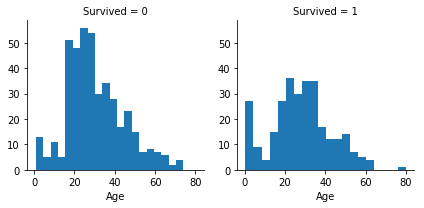

In [12]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20);

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

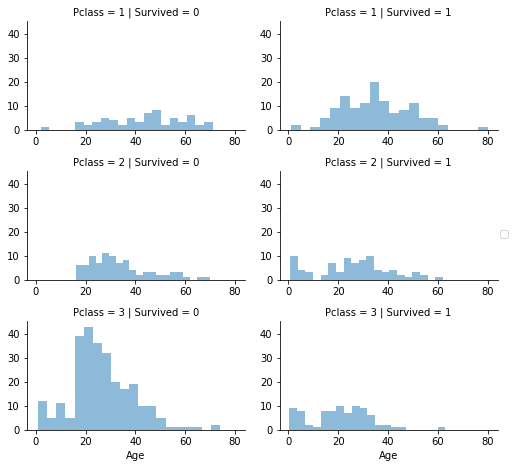

In [13]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


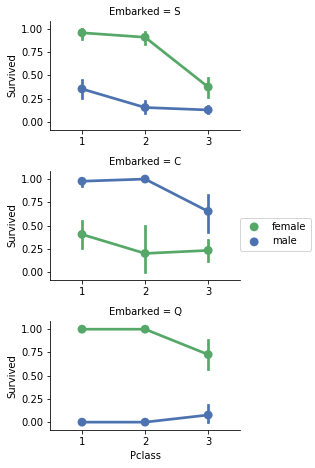

In [14]:
ordered_embarked = train_df.Embarked.value_counts().index

grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend();

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


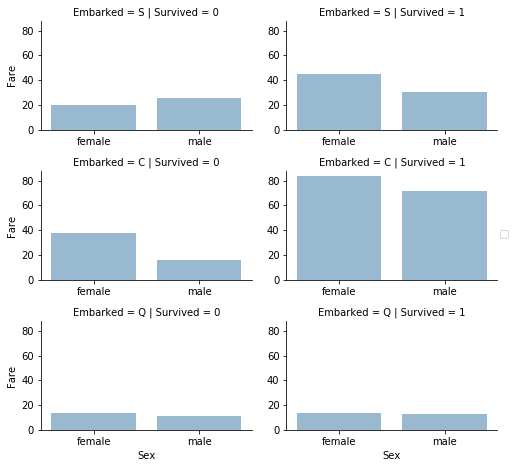

In [15]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend();

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

# Clearning data
## Drop features

In [16]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
train_df = train_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]
print("After ", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After  (891, 9) (418, 9) (891, 9) (418, 9)


## Create new feature
### Create 'Title' and drop 'Name'

In [17]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [18]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', \
                                                 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [19]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [20]:
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

## Convert Sex type to number

In [21]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


## Completing a numerical continuous feature
Methods
- A simple way is to generate random numbers between mean and standard deviation.
- More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...
- Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.


### Age


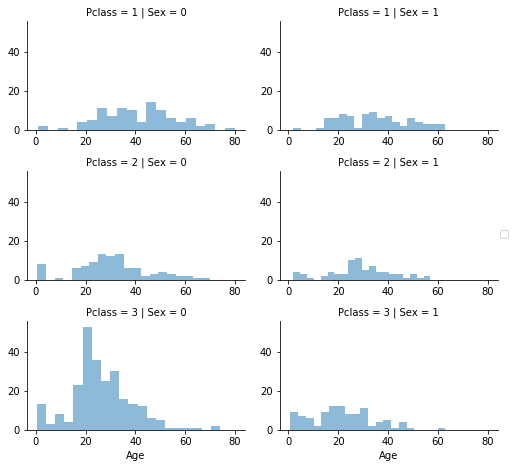

In [22]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [23]:
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [24]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [25]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


## Create feature "FamilySize"

In [26]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[[
    'FamilySize', 
    'Survived',
]].groupby([
    'FamilySize'
], as_index=False)\
.mean()\
.sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


## Create feature "IsAlone"

In [27]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[[
    'IsAlone', 
    'Survived',
]]\
.groupby(['IsAlone'], as_index=False)\
.mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [28]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


## Create artificial feature combining "Pclass and Age."

In [29]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


## Complete missed values of feature "Embarked"

In [30]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[[
    'Embarked', 
    'Survived',
]]\
.groupby(['Embarked'], as_index=False)\
.mean()\
.sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


## Convert feature "Embarked" to numeric

In [31]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


## Complete one missed value for feature "Fare"

In [32]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [33]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[[
    'FareBand', 
    'Survived',
]]\
.groupby(['FareBand'], as_index=False)\
.mean()\
.sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [34]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


# Model, predict and solve